# Part A: Data Analysis

### 1) Is there missing data?

Yes, there is missing data, according to the .names file. In total, there are 16 instances from group 1-6 that are missing some attribute value (denoted by "?").

### 2) Can we afford to remove data points?

If we take the percentage of instances with missing attributes, we get ~2.29% of the data have missing attributes. In this case, it could be fine to omit these values  although it could increase biased estimates. We can afford to remove it, but there is a better alternative through imputation.

### 3) Do we use imputation (and introduce additional uncertainty)?

Imputation can make it simpler if we do replace the missing values with the mean of that feature, but it still adds bias. However, even though it does introduce some uncertainty/bias, so does removing data points, and can be worse since the overall number of samples drops.

# Part B: Feature Engineering

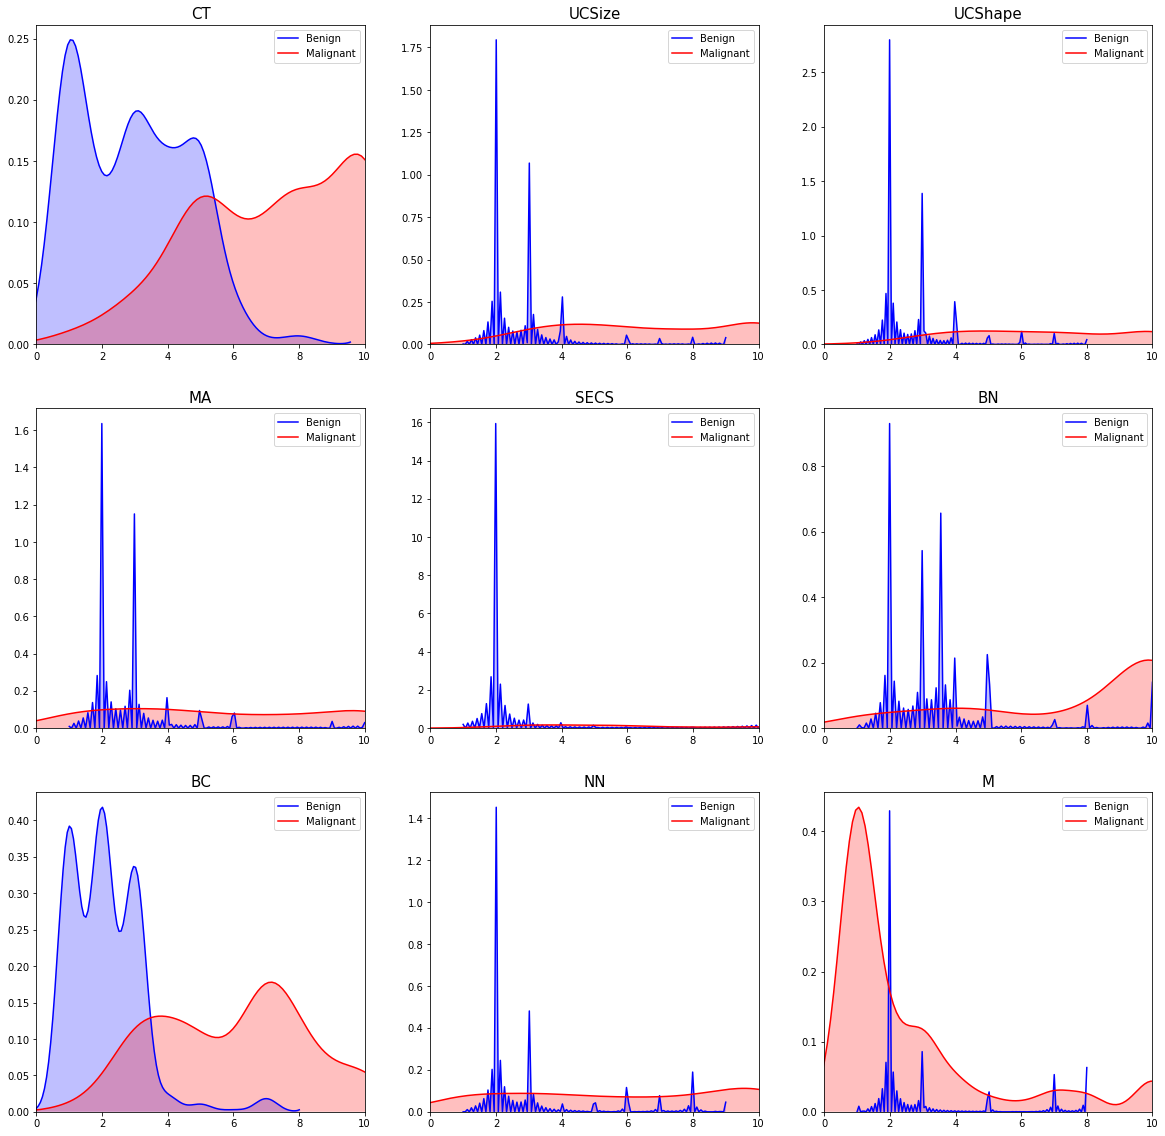

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

imp = SimpleImputer(missing_values=np.nan, strategy="mean")
column_names = ['id','CT','UCSize','UCShape','MA','SECS','BN','BC','NN','M','C']
df = pd.read_csv("breast-cancer-wisconsin.data", header=None)
fig = plt.subplots(3,3,figsize=(20,20))
scaler = preprocessing.MinMaxScaler()
label_dict = {'Benign': 2.0, 'Malignant': 4.0}

#Imputation
'''
We replace all "?" attribute values with an imputation, where in this case we use mean
'''
df = df.replace("?", np.nan)
arr_nd = imp.fit_transform(df)
df = pd.DataFrame(arr_nd, columns=column_names)
nonscaled_df = df.copy()
labels = df['C']
# Feature Distribution Plots For All Features
for i in range(1,len(column_names)-1):
    subplot = plt.subplot(3,3,i)
    subplot.set_xlim([0,10])
    a = sns.kdeplot(nonscaled_df.loc[(nonscaled_df['C']==2.0),column_names[i]], color='b', shade=True, Label='Benign')
    b = sns.kdeplot(nonscaled_df.loc[(nonscaled_df['C']==4.0),column_names[i]], color='r', shade=True, Label='Malignant')
    plt.title(column_names[i], fontsize=15)

# Feature Scaling
df[['CT','UCSize','UCShape','MA','SECS','BN','BC','NN','M']] = scaler.fit_transform(df[['CT','UCSize','UCShape','MA','SECS','BN','BC','NN','M']])


# Part C: Feature Analysis

The best features are: ['CT', 'SECS']


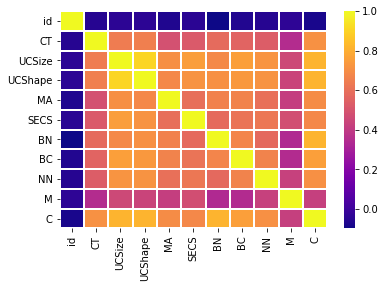

In [7]:
# Heatmap
'''
Create a correlation matrix and create a heatbmap using seaborn
'''
correlation = df.corr()
heatmap=sns.heatmap(correlation,linewidths=1, cmap='plasma')

#Univariate Selection
'''
Using the normalized dataframe, we create a copy version of the normalized df that focuses only on the continuous features
(not the classification or the id number), and then use SelectKBest to show the best 2 features
'''
features_df = df.copy()
features_df = features_df.drop(['C'],axis=1)
features_df = features_df.drop(['id'],axis=1)
X_new = SelectKBest(k=2, score_func=chi2).fit(features_df,labels)
mask = X_new.get_support()
best_feats = []
for b, feature in zip(mask, column_names):
    if b:
        best_feats.append(feature)
print(f'The best features are: {best_feats}')



# Part D: Principal Component Analysis (PCA)

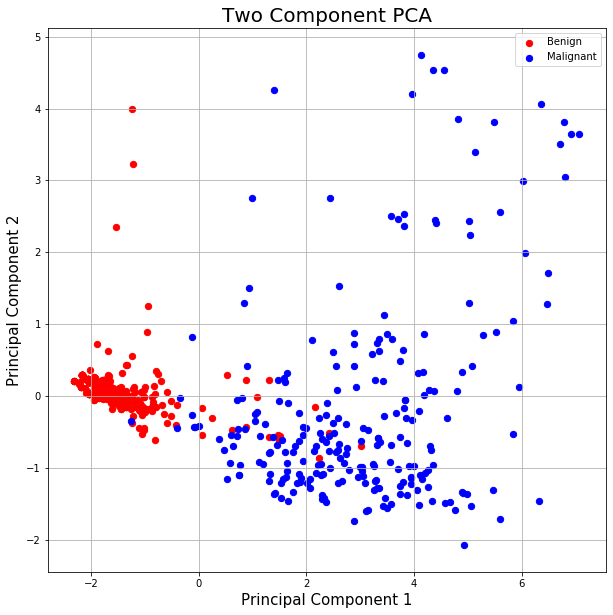

In [8]:
'''
When performing PCA, we can see that there is a line going diagonally downward and separates each of them. PCA helps maximize 
the variance of the data while reducing dimensionality (although there are still some scattered above them, it has been 
drastically reduced overall)
'''
nonscaled_features_df = nonscaled_df.drop(['C'],axis=1)
nonscaled_features_df = nonscaled_features_df.drop(['id'],axis=1)

x = preprocessing.StandardScaler().fit_transform(nonscaled_features_df)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
principal_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])
final_principal_df = pd.concat([principal_df, df[['C']]], axis=1)

fig = plt.figure(figsize = (10,10))
plt.xlabel('Principal Component 1', fontsize=15)
plt.ylabel('Principal Component 2', fontsize=15)
plt.title('Two Component PCA', fontsize=20)
colors = ['r','b']
for label, color in zip(label_dict.keys(), colors):
    indices_to_keep = final_principal_df['C'] == label_dict[label]
    plt.scatter(final_principal_df.loc[indices_to_keep, 'Principal Component 1'] 
                , final_principal_df.loc[indices_to_keep, 'Principal Component 2']
                , c = color
                , s = 40)
plt.legend(label_dict.keys())
plt.grid()

# Part E: KNN Classification Model

Highest Accurate K is: 14 with an accuracy of 0.9714285714285714


(0.0, 11.0)

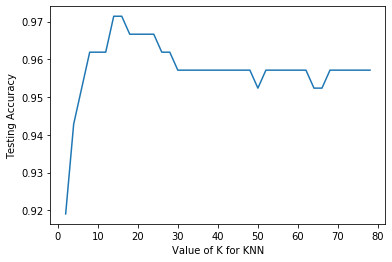

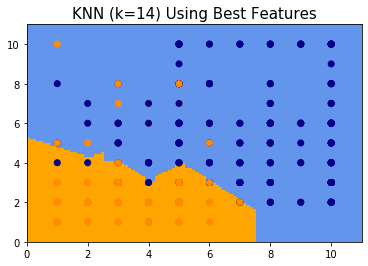

In [9]:
X = nonscaled_features_df.copy()
y = labels.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
scores = []
k_range = [*range(2,80,2)]
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    score = knn.score(X_test,y_test)
    scores.append(score)
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
max_score = max(scores)
index = scores.index(max_score)
print(f'Highest Accurate K is: {k_range[index]} with an accuracy of {max(scores)}')


'''
Assume Scatterplot looks like that due to difficulty putting all ~700 points on a single graph
'''
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

X_new = X[['CT', 'SECS']]
knn=KNeighborsClassifier(n_neighbors=k_range[index], weights='uniform')
knn.fit(X_new, y)
x_min, x_max = X_new.iloc[:, 0].min() - 1, X_new.iloc[:, 0].max() + 1
y_min, y_max = X_new.iloc[:, 1].min() - 1, X_new.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)


plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.title(f'KNN (k={k_range[index]}) Using Best Features', fontsize=15)

plt.scatter(X_new.iloc[:, 0], X_new.iloc[:, 1], c=y, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# Part F: Artificial Neural Network

In [10]:
X = nonscaled_features_df.copy()
y = labels.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# X_train = 559 instances
'''
We have 3 Hidden Layers, Each with 150 hidden nodes, then 100, finally to 50. In total, I wanted to have ~ half the amount
of hidden layer nodes to input nodes which has 559 instances in the training data, since that seemed to be a good estimate
of hidden layer sizes. I also increased the maximum amount of iteration to 500 since it could potentially go through the
initial 300 if the size of the input layer is nearly doubled.
'''
mlp = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=500)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
accuracy_score(y_test,y_pred)


0.9642857142857143